In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import analyze # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm
import datetime


%matplotlib inline

In [3]:
ACTUALLY_OFF = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 
                130, 134, 135, 139, 148, 150, 152, 162, 178, 183,
                190, 198, 206, 213, 214, 234, 239, 244]

In [4]:
import hax
#hax already initiated when analyze is imported

from spe_acceptance import data_dir_base


def data_exists(run_number):
    data_path=os.path.join(data_dir_base, 'run_%05d.h5' %run_number)
    return os.path.exists(data_path)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

def get_run_time(run):
    return hax.runs.datasets[hax.runs.datasets.number == run].start.values[0]

In [5]:
#create runlists, missing runs, runs to resubmit
#accs, occs, runs where LED was likely off

runlists = [f for f in os.listdir('./runlists')]

bottom_runs = []
topb_runs = []
topring_runs = []
accs = []
errors = []

missing_runs = []
LED_off = []
resubmit_files = []

for f in tqdm(sorted(runlists)):
    runlist = file_to_list(f)
    if not all_data_exists(runlist):
        resubmit_files.append(f)
        #print('data missing for %s' % f)
        for r in runlist:
            if not data_exists(r):
                missing_runs.append(r)
        continue
        
    bottom_run = runlist[0]
    topbulk_run = runlist[1]
    topring_run = runlist[2]
    
    thresholds = analyze.get_thresholds(analyze.find_regular_run(bottom_run))
    
    acc, acc_errs = analyze.acceptance_3runs(bottom_run, topbulk_run, topring_run, thresholds)
    occ, occ_errs = analyze.occupancy_3runs(bottom_run, topbulk_run, topring_run)
    
    on_channels = np.where(occ > 0.05)[0]
    
    if len(on_channels) < 200:
        LED_off.append(f)
        #print('LED likely OFF for %s' % f)
        continue
    
    acc = acc[on_channels]
    acc_errs = acc_errs[on_channels]
    
    accs.append(np.mean(acc))
    errors.append(np.sqrt((acc_errs**2).sum()) / len(on_channels))
    bottom_runs.append(bottom_run)
    topb_runs.append(topbulk_run)
    topring_runs.append(topring_run)
    
print("These runs are missing data: ", missing_runs)
print("LED likely off for these files: ", LED_off)

 18%|█▊        | 18/102 [00:49<03:22,  2.42s/it]/home/awalsh272/SPE/SPE/analyze.py:63: RuntimeWarning: divide by zero encountered in true_divide
  acc =  1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
/home/awalsh272/SPE/SPE/analyze.py:63: RuntimeWarning: invalid value encountered in true_divide
  acc =  1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
 55%|█████▍    | 56/102 [02:03<02:06,  2.74s/it]/home/awalsh272/SPE/SPE/analyze.py:31: RuntimeWarning: divide by zero encountered in log
  occupancy_array[:,i] = -1*np.log(self.make_correction(val, 'amplitude'))
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
100%|██████████| 102/102 [03:47<00:00,  2.37s/it]

These runs are missing data:  [11278, 11279, 11352, 11353, 11354, 11535, 11536, 14370, 14371, 14734, 14735, 14907, 15087, 15268, 15811, 15812, 15813, 15987, 15988, 15989, 16237, 16238, 16239, 4511, 4512, 4513, 4688, 4689, 4848, 4851, 4850, 4956, 4958, 4957, 5949, 5950, 5951, 6052, 6053, 6248, 6249, 6647, 6836, 7100]
LED likely off for these files:  ['runlist_13433_13434_13435.txt', 'runlist_14088_14089_14090.txt']


In [6]:
#prints low acceptance bottom runs (<0.7)
bottom_runs = np.array(bottom_runs)
accs = np.array(accs)

print('low acceptance bottom runs: ',bottom_runs[np.where(accs < 0.7)])

low acceptance bottom runs:  [13837]


In [7]:
def acceptance_curve_3runs(bottom_run, topbulk_run, topring_run):
    ret_acc, ret_errs = np.ones((248, 1099)), np.ones((248, 1099))
    run_list = [bottom_run, topbulk_run, topring_run]
    channel_lists = [channel_dict['bottom_channels'],
                     channel_dict['top_bulk'],
                     channel_dict['top_outer_ring']]
    for run, ch_list in zip(run_list, channel_lists):
        path = os.path.join(data_dir_base, 'run_%05d.h5' % run)
        if not os.path.exists(path):
            print("Acceptance data does not exist for run %d" % run)
        s = analyze.SPE(path)
        frac, errs = s.acceptance_by_channel
        ret_acc[ch_list] = frac[ch_list]
        ret_errs[ch_list] = errs[ch_list]
    return ret_acc, ret_errs

def find_file(run):
    return [f for f in os.listdir('runlists') if str(run) in f]

## Analysis on Outlier Runs

Run:  12398
Acceptance:  0.851812904967
[[ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]
 ..., 
 [ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]
 [ 1.  1.  1. ...,  0.  0.  0.]]


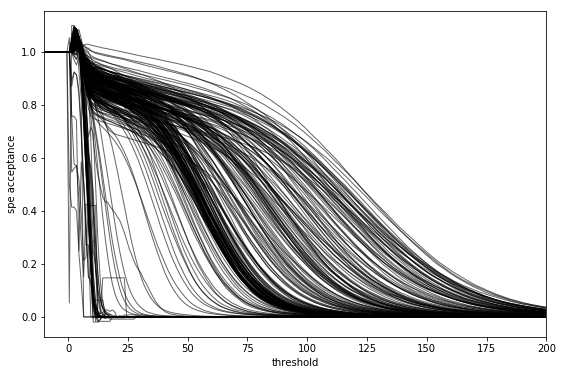

In [8]:
#Find outliers, plot acc of one of them
outlier_indices = np.where(accs < 0.85)
outliers = bottom_runs[outlier_indices]
run = outliers[1]
print('Run: ',run)
s = analyze.SPE('data/run_%05d.h5' % run)
x = s.data['bin_centers'].copy()
runlist = file_to_list(find_file(run)[0])
#acc = s.acceptance(6)
acc, err = acceptance_curve_3runs(runlist[0], runlist[1], runlist[2])
thresholds = analyze.get_thresholds(analyze.find_regular_run(int(run)))

acc_frac = acc[np.arange(248), 100 + np.array(thresholds[:248])]
print('Acceptance: ', np.median(acc_frac))
print(acc)
plt.figure(figsize=(9,6))
for ch, a in enumerate(acc):
    plt.plot(x, a, color='black', linewidth=1, alpha=0.6)
    
plt.xlim(-10, 200)
plt.xlabel('threshold')
plt.ylabel('spe acceptance')
#plt.savefig('acceptance_curve_%05d.png' % run)
plt.show()


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[ 0.9308656   0.99877251  0.93215398  0.93684564  0.92419332  0.92401392
  0.93189899  0.94677121  0.93365919  0.93973219  0.93468015  0.94001819
  0.9949404   0.93081562  0.94023382  0.93828494  0.93505297  0.92747792
  0.93568718  0.94005075  0.93346405  0.93567489  0.93400867  0.93620027
  0.94052172  0.93971697  0.98885066  0.94885424  0.94003336  0.93483319
  0.93879258  0.93917508  0.92303024  0.93158904  0.99844277  0.9232192
  0.9103583   0.92241838  0.88024222  0.89078598  0.89526506  0.91068679
  0.90975832  0.90313104  0.89359021  0.90972039  0.91331442  0.9096261
  0.9156427   0.92538296  0.8939994   0.91580661  0.91716022  0.90821161
  0.91881732  0.91487964  0.92610824  0.91990917  0.90543782  0.90825399
  0.90463284  0.91745267  0.95488956  0.90764152  0.90886516  0.9860806


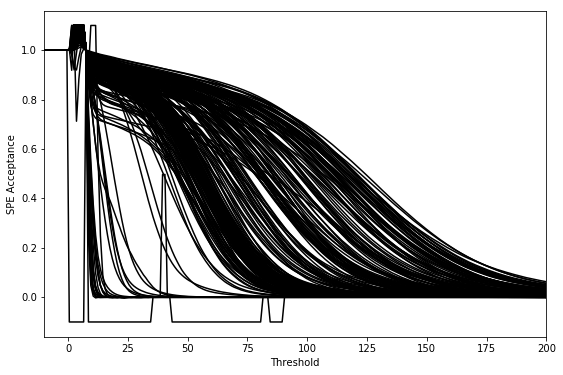

In [73]:
#recalculates acc instead of relying on analyze
#Does this for all outlier runs
led = []
noise = []
for run in outliers:
    s = analyze.SPE('data/run_%05d.h5' % run)
    led.append(s.data['LED_amplitude'])
    noise.append(s.data['noise_amplitude'])


led = np.array(led)
noise = np.array(noise)
led = led.sum(axis=0)
print(led)
noise = noise.sum(axis=0)
corr = led[:108, :].sum(axis=0) / noise[:108, :].sum(axis=0)
noise *= corr
print(corr)
print(noise)

residual = (led - noise).T

acceptance = 1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
print(acceptance)
acceptance = np.clip(acceptance, -0.1, 1.1)

plt.figure(figsize=(9,6))
for ch, acc in enumerate(acceptance):
    plt.plot(x, acc, color='k')
plt.xlabel('Threshold')
plt.ylabel('SPE Acceptance')
plt.xlim(-10,200)
plt.show()

In [28]:
#finds thresholds, acc, occ and acc and occ errs for a single runlist
#Should be runlist of an outlier run

runlist='runlist_14192_14193_14195.txt'
runs = runlist.split('_')[1:4]
bot_run = int(runs[0])
tb_run = int(runs[1])
tr_run = int(runs[2][:-4])

thresholds = analyze.get_thresholds(analyze.find_regular_run(bot_run))
acc, err = analyze.acceptance_3runs(bot_run, tb_run, tr_run, thresholds)
occ, occ_err = analyze.occupancy_3runs(bot_run, tb_run, tr_run)

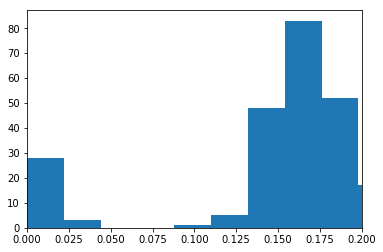

In [29]:
#plot the occupancy of one runlist
plt.hist(occ, bins=50, range=(0,1.1))
plt.xlim(0,0.2)
plt.show()

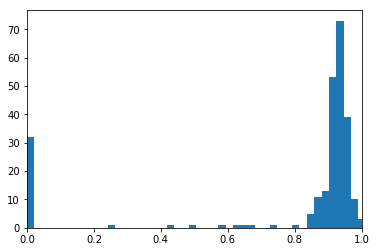

In [30]:
#plot the acceptance of one runlist
plt.hist(acc, bins=50, range=(0,1.1))
plt.xlim(0, 1)
plt.show()

In [31]:
# get date of specific run

from make_runlist_new import get_dates
date_dict=get_dates(bottom_runs)

bad_run=14192
bad_date=date_dict[bad_run]
print('y/m/d')
print(bad_date)

y/m/d
2017-11-03 09:45:07


In [40]:
#checks if channels that register as off are only the ones we know are actually off

my_off = np.where(occ < 0.07)[0]
print('in my_off but not actually_off:', [ch for ch in my_off if ch not in ACTUALLY_OFF])
print('opposite: ', [ch for ch in ACTUALLY_OFF if ch not in my_off])

in my_off but not actually_off: [137]
opposite:  [148]


## Analysis of Systematic Errors

In [41]:
#Sets up checks for arbitrary bin choice
from spe_acceptance import data_dir_base #/project/lgrandi/xenon1t/spe_acceptance/data
path = os.path.join(data_dir_base, 'run_%05d.h5' % tr_run)
s = analyze.SPE(path)
vals_to_check = [3,4,5,6,7,8,9]
occ_array = np.ones((248, len(vals_to_check)))
for i, val in enumerate(vals_to_check):
    occ_array[:,i] = -1*np.log(s.make_correction(val, 'amplitude'))
occ = np.mean(occ_array, axis=1)
myoff = np.where(occ < 0.1)[0]

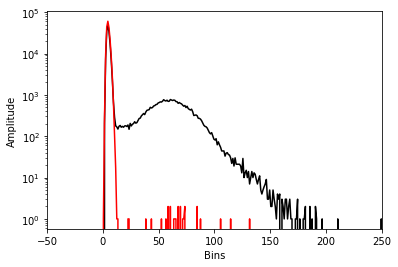

In [42]:
#plot LED and noise vs bins
plt.plot(s.data['bin_centers'], s.data['LED_amplitude'][:,0], color='black')
plt.plot(s.data['bin_centers'], s.data['noise_amplitude'][:,0], color='red')
plt.yscale('log')
plt.ylabel('Amplitude')
plt.xlabel('Bins')
plt.xlim(-50, 250)
plt.show()

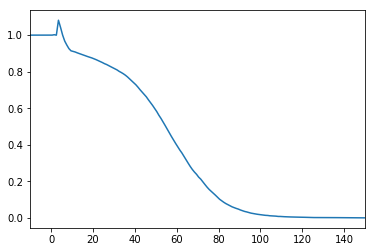

In [44]:
#plot a single acc curve vs just a channel on the same run

#checks if data for run exists
run_number = 14192
path = os.path.join(data_dir_base, 'run_%05d.h5' % run_number)
if not os.path.exists(path):
    print("Acceptance data does not exist for run %d" % run_number)
s = analyze.SPE(path)    

ch = 0

acc = s.acceptance(6, 'amplitude')
#x, acc2, acc2_errs = analyze.ch_curve(ch, run_number) #x is s.data['bin_centers']
#print(x, acc2, acc2_errs)
plt.plot(x, acc[ch])
#plt.errorbar(x, acc2, yerr=acc2_errs)
plt.xlim(-10, 150)
plt.show()

In [45]:
def acceptance_fraction(run_number, thresholds):
    path = os.path.join(data_dir_base, 'run_%05d.h5' % run_number)
    if not os.path.exists(path):
        print("Acceptance data does not exist for run %d" % run_number)
    s = analyze.SPE(path)
    frac_array = np.ones((248, s.big_array.shape[-1]))
    ch_index = np.arange(248)
    thresholds = np.array(thresholds)
    bin0 = np.where(s.data['bin_centers'] == 0.5)[0][0]
    for i in range(s.big_array.shape[-1]):
        frac_array[:,i] = s.big_array[...,i][ch_index, thresholds[:248] + bin0]
    acc_frac = np.mean(frac_array, axis=1)
    acc_errs = np.std(frac_array, axis=1)
    return acc_frac, acc_errs

In [46]:
thresholds = analyze.get_thresholds(analyze.find_regular_run(int(run)))
new_accs = analyze.acceptance_3runs(*tuple(runlist), thresholds=thresholds)[0]
print(accs)
thresh = np.array(thresholds)
len(thresh)

[ 1.  1.  1. ...,  0.  0.  0.]


260

In [47]:
run_number = 15628
path=os.path.join(data_dir_base, 'run_%05d.h5' % run_number)
s = analyze.SPE(path)

#acceptance fraction defined above, otherwise need to do analyze.acceptance_fraction
frac, errs = acceptance_fraction(run_number, thresh)

In [48]:
arr = np.ones(5)
arr[[2,4]] = [2,2]
print(arr)
arr=s.big_array

[ 1.  1.  2.  1.  2.]


In [56]:
from channel_dict import channel_dict

bot_run = 15625
tb_run = 15627
tr_run = 15628

bottom = channel_dict['bottom_channels']
topbulk = channel_dict['top_bulk']
topring = channel_dict['top_outer_ring']

real_acc, real_errs = np.ones(248), np.ones(248)

for run, channels in zip([bot_run, tb_run, tr_run], [bottom, topbulk, topring]):
    frac, errs = acceptance_fraction(run_number, thresh)
    real_acc[channels] = frac[channels]
    real_errs[channels] = errs[channels]

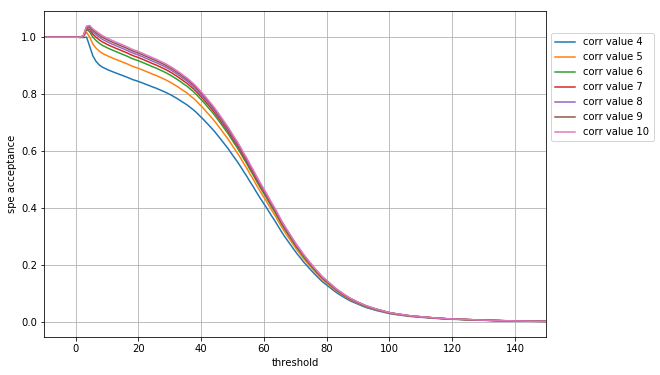

In [51]:
#Plots the acceptance vs threshold for each bin choice
example_run = sorted(bottom_runs)[-1]
runlist = file_to_list(find_file(example_run)[0])
ch = 0
s = analyze.SPE('data/run_%05d.h5' % runlist[2])
x = s.data['bin_centers']
corr_values = [4,5,6,7,8,9,10]

plt.figure(figsize=(9,6))
for i in range(s.big_array.shape[-1]):
    accs = s.big_array[ch,:,i]
    plt.plot(x, accs, label='corr value %d' % corr_values[i])
plt.xlim(-10, 150)
plt.legend(loc=(1.01, 0.6))
plt.grid()
plt.xlabel('threshold')
plt.ylabel('spe acceptance')
plt.savefig('example_systematic.png')
plt.show()
    


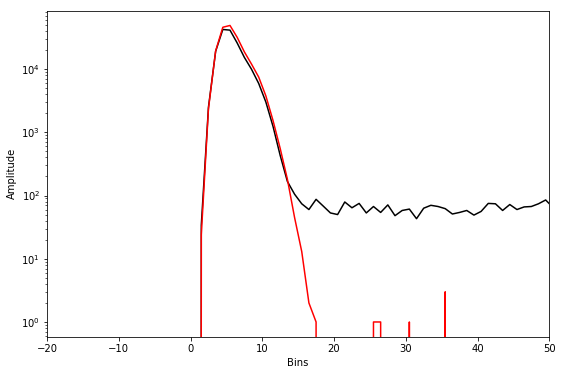

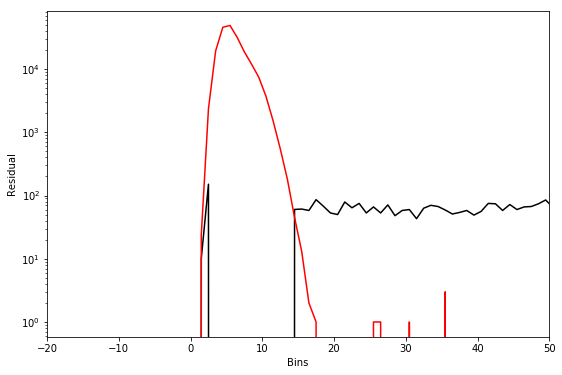

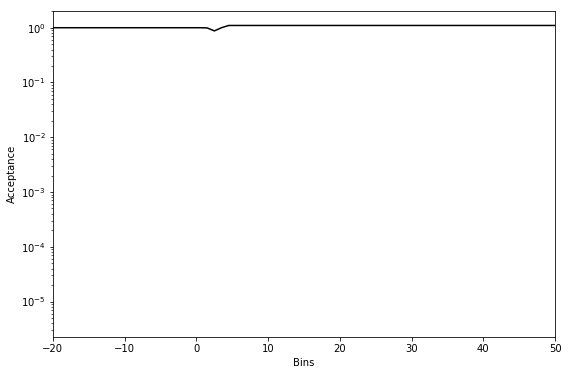

In [55]:
#Systematics

ch = 193
run = 11069
s = analyze.SPE('data/run_%05d.h5' % run)

x = s.data['bin_centers']

#Bins vs LED/Noise Amplitude for individual channel

plt.figure(figsize=(9,6))
plt.plot(x, s.data['LED_amplitude'][:,ch], color ='black')
plt.plot(x, s.data['noise_amplitude'][:,ch], color='red' )
plt.xlabel('Bins')
plt.ylabel('Amplitude')
plt.xlim(-20, 50)
plt.yscale('log')
plt.show()

#Bins vs Residual Value for individual channel
val = 4
plt.figure(figsize=(9,6))
plt.plot(x, s.residual(val)[ch], color ='black')
plt.plot(x, s.data['noise_amplitude'][:,ch], color='red' )
plt.xlim(-20, 50)
plt.xlabel('Bins')
plt.ylabel('Residual')
plt.yscale('log')
plt.show()

#Bins vs acceptance for individual channel
plt.figure(figsize=(9,6))
plt.plot(x, s.acceptance(val)[ch], color ='black')
#plt.plot(x, s.data['noise_amplitude'][:,ch], color='red' )
plt.xlabel('Bins')
#plt.yscale('log')
plt.ylabel('Acceptance')
plt.xlim(-20, 50)
plt.show()